In [1]:
# loading packages
import os
import numpy as np
import pandas as pd
import scanpy as sc
import pybiomart
import seaborn as sns
import scrublet as scr
import scipy
from scipy import io
import pandas as pd
import seaborn as sns
from io import StringIO
from scipy.stats import ranksums
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.patches import Patch
sc.settings.verbosity=3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
    # scanpy==1.7.0
    # anndata==0.7.5
    # umap==0.3.10 numpy==1.18.1
    # scipy==1.4.1 pandas==1.2.2
    # scikit-learn==0.22.2.post1
    # statsmodels==0.12.2
    # python-igraph==0.8.3
    # louvain==0.6.1
    # leidenalg==0.8.3

#sc.settings.set_figure_params(dpi=120, facecolor='white')


scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 pynndescent==0.5.2


In [2]:
# read in the counts matrix into a AnnData object
os.chdir("C:/Users/Owner/OneDrive - Johns Hopkins/Desktop/spQSP-HCC/singleCell/Cabo_Nivo_aggr_GE/")
adata=sc.read_10x_mtx(
    'filtered_feature_bc_matrix/',
    var_names='gene_symbols', cache=True)

adata.var_names_make_unique()
adata

... reading from cache file cache\filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 411562 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
adata.obs['samples'] = np.where(adata.obs.index.str.endswith('-1'),'HCC12',
                        np.where(adata.obs.index.str.endswith('-2'),'HCC13',
                        np.where(adata.obs.index.str.endswith('-3'),'HCC14',
                        np.where(adata.obs.index.str.endswith('-4'),'HCC15',
                        np.where(adata.obs.index.str.endswith('-5'),'HCC02',
                        np.where(adata.obs.index.str.endswith('-6'),'HCC20',
                        np.where(adata.obs.index.str.endswith('-7'),'HCC21',
                        np.where(adata.obs.index.str.endswith('-8'),'HCC04',
                        np.where(adata.obs.index.str.endswith('-9'),'HCC08',
                        np.where(adata.obs.index.str.endswith('-10'),'HCC09',
                        np.where(adata.obs.index.str.endswith('-11'),'HCCT1',
                        'HCCT2')))))))))))

adata.obs['response'] = np.where(adata.obs.index.str.endswith('-1'),'no',
                        np.where(adata.obs.index.str.endswith('-2'),'yes',
                        np.where(adata.obs.index.str.endswith('-3'),'yes',
                        np.where(adata.obs.index.str.endswith('-4'),'no',
                        np.where(adata.obs.index.str.endswith('-5'),'yes',
                        np.where(adata.obs.index.str.endswith('-6'),'no',
                        np.where(adata.obs.index.str.endswith('-7'),'no',
                        np.where(adata.obs.index.str.endswith('-8'),'no',
                        np.where(adata.obs.index.str.endswith('-9'),'yes',
                        np.where(adata.obs.index.str.endswith('-10'),'no',
                        np.where(adata.obs.index.str.endswith('-11'),'no',
                        'no')))))))))))

normalizing counts per cell
    finished (0:00:00)


C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


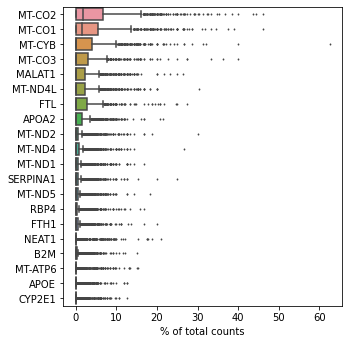

... storing 'samples' as categorical
... storing 'response' as categorical
... storing 'feature_types' as categorical


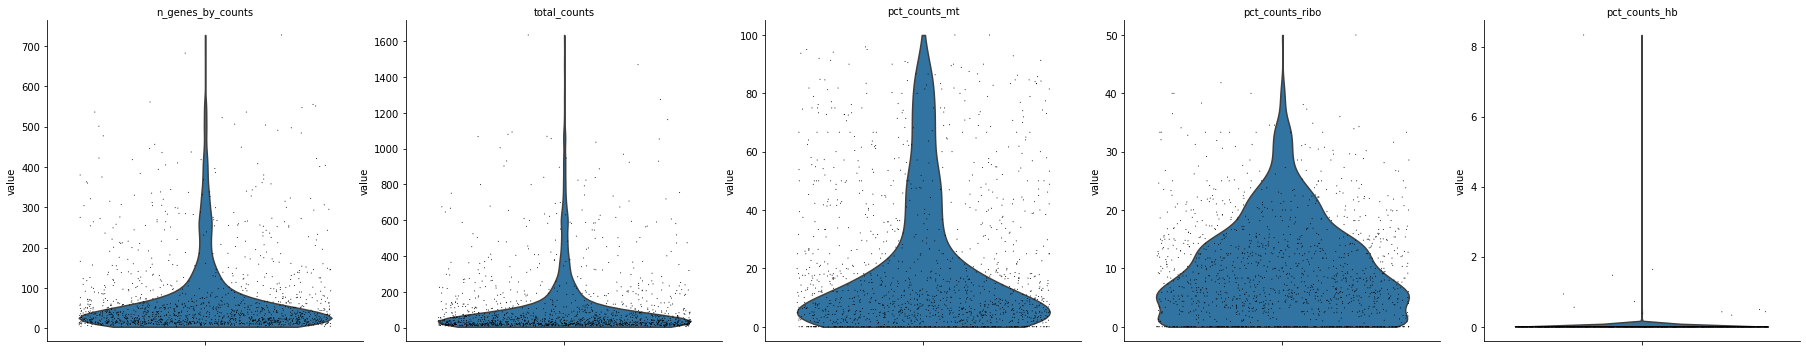

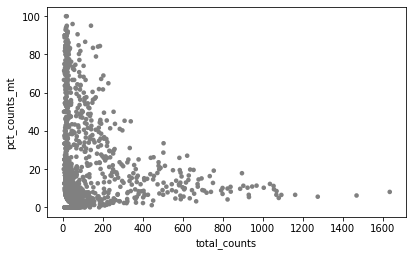

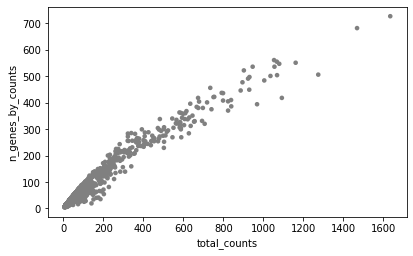

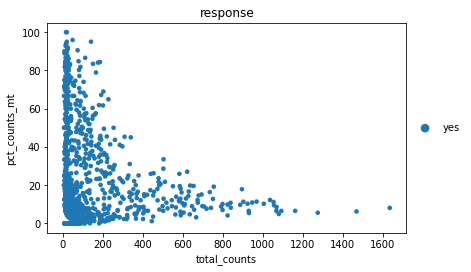

In [4]:
## Patient selection
patient = 'HCC13'
adata = adata[adata.obs['samples'] == patient]
# QC and filtering
# genes with the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

# computing metrics for MT genes
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# annotate ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))

# annotate hemoglobin genes
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(adata,
                            qc_vars=['mt','ribo','hb'],
                            percent_top=None,
                            log1p=False, inplace=True)

sc.pl.violin(adata,['n_genes_by_counts','total_counts','pct_counts_mt',
    'pct_counts_ribo','pct_counts_hb'], jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = 'response')


In [5]:
## Filter out genes that have low expression and cell have too much MT expression
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)
adata = adata[adata.obs["pct_counts_mt"] < 25]
print(f"#cells after MT filter: {adata.n_obs}")
#######################################################################################################
gene_name = pd.Series(adata.var.index)
gene_name.index = adata.var.index
genes = pd.concat([adata.var['gene_ids'], gene_name, adata.var['feature_types']], axis=1)
#########################################################################
pd.DataFrame(genes).to_csv("data/hcc13/genes.tsv",  sep = "\t", index = False, header = False)
pd.DataFrame(adata.obs.index).to_csv("data/hcc13/barcodes.tsv", sep = "\t", index = False, header = False)
# save the raw expression matrix, will lognormalize in the Domino analysis
scipy.io.mmwrite("data/hcc13/matrix.mtx", adata.X.T) 

filtered out 1147 cells that have less than 100 genes expressed
filtered out 30418 genes that are detected in less than 2 cells
#cells after MT filter: 226


In [6]:
#pd.concat([adata.var['gene_ids'], gene, adata.var['feature_types']], axis=1)

normalizing counts per cell
    finished (0:00:00)


C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


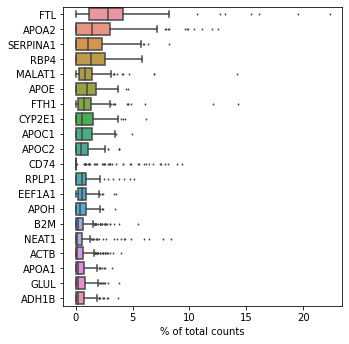

normalizing counts per cell
    finished (0:00:00)


C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\scanpy\preprocessing\_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
non_mito_genes_list=[
    name for name in adata.var_names if not name.startswith('MT-')]
adata_nomt=adata[:, non_mito_genes_list]

sc.pl.highest_expr_genes(adata_nomt, n_top=20)

# total-count normalization
sc.pp.normalize_total(adata_nomt, target_sum=1e4)

adata_nomt.write(
    'cabonivo_nomt_preproc.h5ad',
    compression='gzip')

#%%
# log scale the data
sc.pp.log1p(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


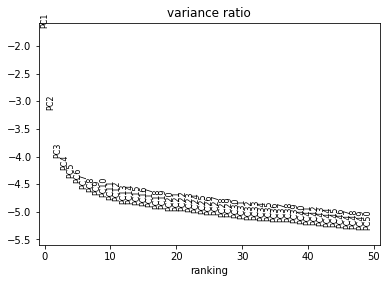

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 6 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


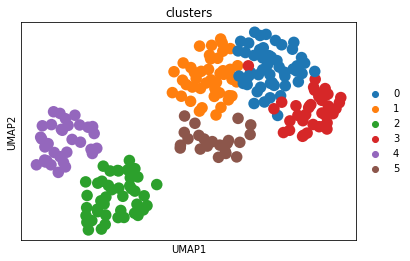

In [8]:
# clustering using umap
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata,n_pcs=50,log=True)

sc.pp.pca(adata,n_comps=50)
sc.pp.neighbors(adata,n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='clusters')
sc.pl.umap(adata, color = 'clusters')

In [9]:
new_cluster_names = ['Cancer Cell (CYP2E1)', 'Cancer Cell (NEAT1)', 'Fibroblasts',
                     'Cancer Cell(FTL)', 'APCs', 'Cancer Cell (AKR1C2)']

adata.rename_categories('clusters', new_cluster_names)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


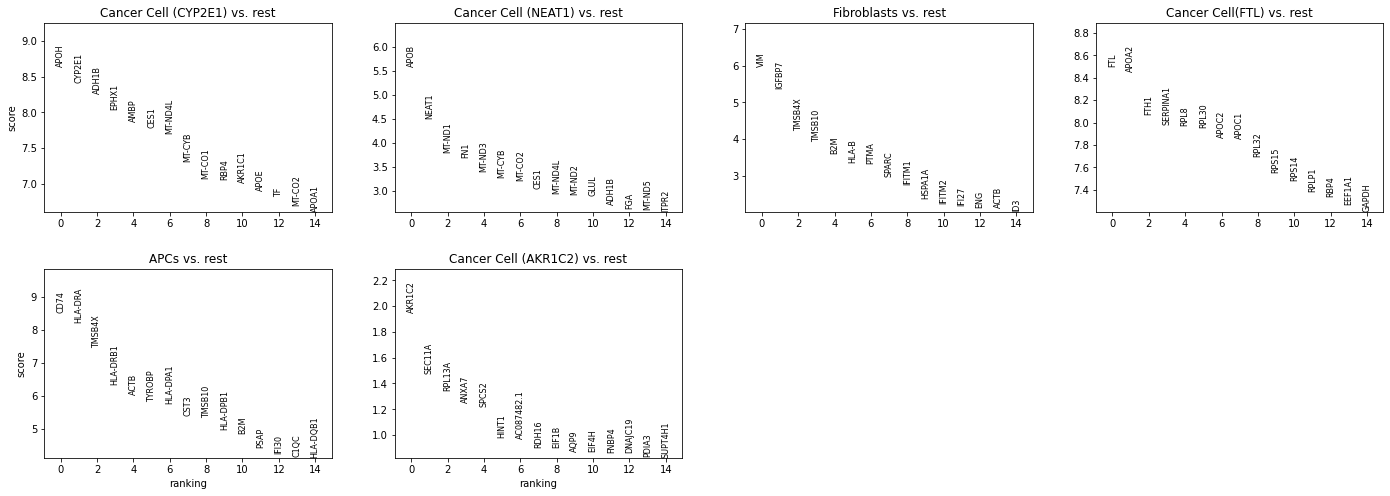

In [10]:
# zoom in specific regions
# sc.pl.spatial(adata, img_key="hires", color="clusters",
#     crop_coord=[1200, 1700, 1900, 1000], alpha=0.5, size=1.3)

### cluster marker genes

sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)


In [11]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,Cancer Cell (CYP2E1),Cancer Cell (NEAT1),Fibroblasts,Cancer Cell(FTL),APCs,Cancer Cell (AKR1C2)
0,APOH,APOB,VIM,FTL,CD74,AKR1C2
1,CYP2E1,NEAT1,IGFBP7,APOA2,HLA-DRA,SEC11A
2,ADH1B,MT-ND1,TMSB4X,FTH1,TMSB4X,RPL13A
3,EPHX1,FN1,TMSB10,SERPINA1,HLA-DRB1,ANXA7
4,AMBP,MT-ND3,B2M,RPL8,ACTB,SPCS2


In [12]:
pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']).head(5)

,Cancer Cell (CYP2E1),Cancer Cell (NEAT1),Fibroblasts,Cancer Cell(FTL),APCs,Cancer Cell (AKR1C2)
0,3.484573e-14,0.000140,5.582445e-07,8.906332e-14,8.779063e-14,0.992026
1,1.279812e-13,0.007368,1.482480e-05,8.906332e-14,6.095446e-13,0.992026
2,3.174689e-13,0.080295,3.327449e-03,1.460281e-12,1.665776e-10,0.992026
3,1.523116e-12,0.096220,1.084025e-02,1.908261e-12,1.682975e-07,0.992026
4,4.628256e-12,0.169493,3.164885e-02,1.908261e-12,7.872051e-07,0.992026


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`


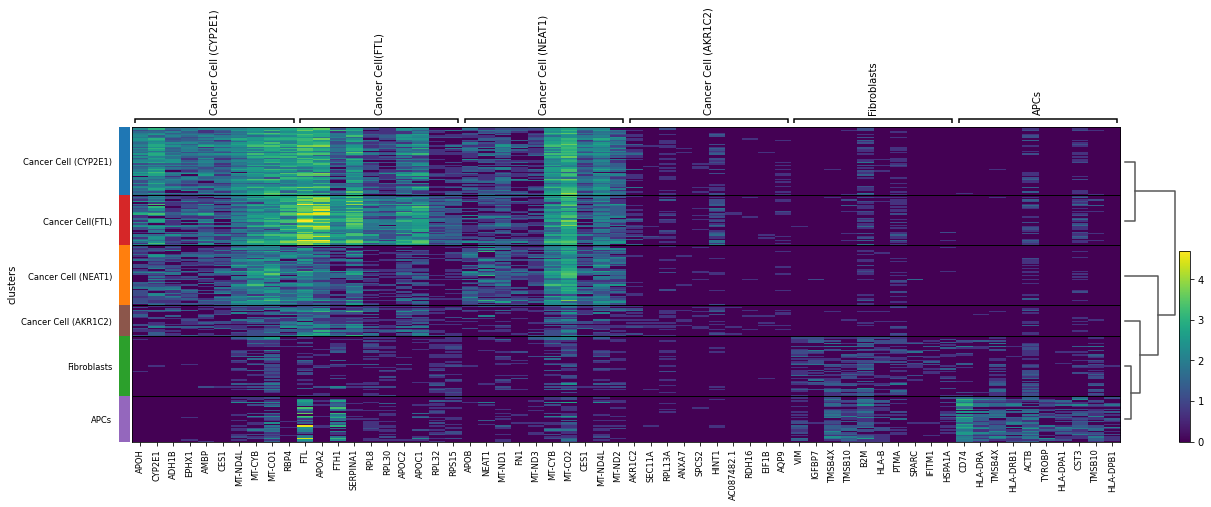

In [13]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True)

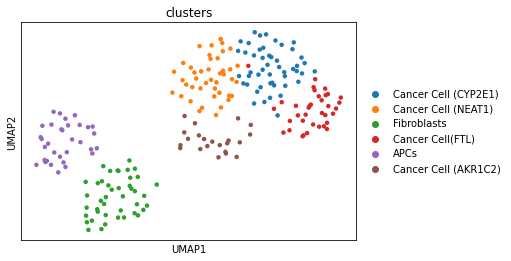

In [14]:
#sc.settings.set_figure_params(dpi=600, facecolor='white')
sc.pl.umap(adata, color = 'clusters', size=80, save='_1.png', )

In [15]:
patienti_ID = 1541
p1p8_matrix=pd.read_csv('../../VisiumData/CoGAPS/{}/1541_15Patterns_SpaceMarkers_residual_Pattern_1 x Pattern_8Fri_Mar_18_20.42.04_2022.txt'.format(patienti_ID), sep=" ",header=None, index_col = 0)
p2p8_matrix=pd.read_csv('../../VisiumData/CoGAPS/{}/1541_15Patterns_SpaceMarkers_residual_Pattern_2 x Pattern_8Fri_Mar_18_20.42.04_2022.txt'.format(patienti_ID), sep=" ",header=None, index_col = 0)



In [16]:
p1p8_matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,,,,,,,,,,
SPINK1,SPINK1,vsBoth,1379,3,2,153.024281,5.904725e-34,1.231172e-33,-4.476063,-11.509065,-7.727346,0.000008,1.187591e-30,1.098122e-14,0.000026,8.414563e-30,5.137015e-14
LCN2,LCN2,vsBoth,1379,3,2,147.952325,7.456942e-33,1.517481e-32,-2.338951,-10.356397,-9.149892,0.019338,3.914316e-25,5.699051e-20,0.053984,2.400077e-24,3.055461e-19
DEFB1,DEFB1,vsBoth,1379,3,2,122.268581,2.816534e-27,5.045605e-27,-3.490650,-10.076478,-7.322474,0.000482,7.019703e-24,2.434407e-13,0.001523,4.154103e-23,1.097717e-12
TAGLN2,TAGLN2,vsBoth,1379,3,2,107.936236,3.647071e-24,6.076517e-24,-2.962674,-9.325798,-7.125428,0.003050,1.101515e-20,1.037580e-12,0.009122,5.997201e-20,4.576650e-12
S100A6,S100A6,vsBoth,1379,3,2,103.995371,2.616327e-23,4.263360e-23,-3.356961,-9.352008,-6.643478,0.000788,8.599900e-21,3.063671e-11,0.002452,4.698578e-20,1.290568e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIPA,LIPA,vsPattern_8,1379,3,2,6.537326,3.805727e-02,3.947238e-02,-0.973574,-2.397431,-1.556119,0.330268,1.651049e-02,1.196799e-01,0.781244,4.638451e-02,3.052965e-01
SHC1,SHC1,vsPattern_8,1379,3,2,6.339621,4.201156e-02,4.351285e-02,-1.675179,-2.517467,-0.784928,0.093899,1.182019e-02,4.324960e-01,0.242589,3.365654e-02,9.979025e-01
GCSH,GCSH,vsPattern_1,1379,3,2,6.301767,4.281428e-02,4.433651e-02,-2.415751,-1.137381,1.802939,0.015703,2.553791e-01,7.139785e-02,0.044204,6.176279e-01,1.871840e-01


In [17]:
npatterns = 15
projectionCoGAPs = pd.read_csv('../../pySCENIC/SingleCell/{}/projection_{}_{}.csv'.format(patient, patient, npatterns), index_col=0).T
projectionCoGAPs = projectionCoGAPs[['Pattern_1', 'Pattern_2', 'Pattern_8']]
projectionCoGAPs['Pattern_Cluster'] = projectionCoGAPs.idxmax(axis=1)
projectionCoGAPs.to_csv("data/cogap/hcc13/projection_{}_128.csv".format(npatterns))

"""projectionCoGAPs['Pattern_Cluster'] = projectionCoGAPs['Pattern_Cluster'].replace({
                                             "Pattern_3": "Pattern_Other", "Pattern_4": "Pattern_Other",
                                             "Pattern_5": "Pattern_Other", "Pattern_6": "Pattern_Other",
                                             "Pattern_7": "Pattern_Other", "Pattern_9": "Pattern_Other"})
"""
#projectionSingleCell = pd.read_csv('../../pySCENIC/SingleCell/{}/singleCll_projection_{}.csv'.format(patient, patient, npatterns), index_col=0).T
#projectionSingleCell
projectionCoGAPs

,Pattern_1,Pattern_2,Pattern_8,Pattern_Cluster
AAACGGGGTCAAAGCG-2,0.426137,0.297942,-0.140666,Pattern_1
AAAGCAATCCCTGACT-2,0.338431,0.375629,-0.186396,Pattern_2
AAATGCCAGCCTTGAT-2,0.279862,0.209473,0.057655,Pattern_1
AACCATGCACATTAGC-2,0.273350,0.352377,-0.003177,Pattern_2
AACTCAGTCCGAGCCA-2,0.138223,0.322022,0.009854,Pattern_2
...,...,...,...,...
TTGGAACAGTCAAGGC-2,0.308354,0.333696,-0.136613,Pattern_2
TTGGCAAGTAAGGGAA-2,0.166991,0.081342,0.144659,Pattern_1
TTTACTGCACCTCGGA-2,0.288066,0.189072,0.032460,Pattern_1
TTTACTGGTTGATTCG-2,0.349722,0.077177,0.171583,Pattern_1


In [18]:
adata.obs=pd.concat([adata.obs, projectionCoGAPs.loc[adata.obs.index,:]], axis=1)
#adata.obs=pd.concat([adata.obs, projectionSingleCell.loc[adata.obs.index,:]], axis=1)
adata

AnnData object with n_obs × n_vars = 226 × 6183
    obs: 'samples', 'response', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'clusters', 'Pattern_1', 'Pattern_2', 'Pattern_8', 'Pattern_Cluster'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'response_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors', 'rank_genes_groups', 'dendrogram_clusters'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

... storing 'Pattern_Cluster' as categorical


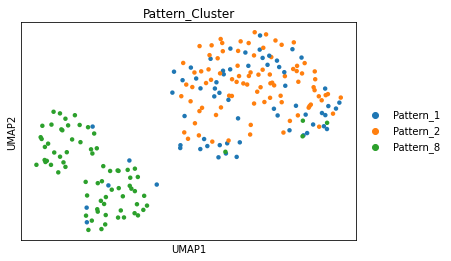

In [19]:
sc.pl.umap(adata, color = 'Pattern_Cluster', size =80)

In [20]:
adata.obs.groupby('Pattern_Cluster').count()


,samples,response,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,n_genes,clusters,Pattern_1,Pattern_2,Pattern_8
Pattern_Cluster,,,,,,,,,,,,,,,
Pattern_1,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
Pattern_2,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88
Pattern_8,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74


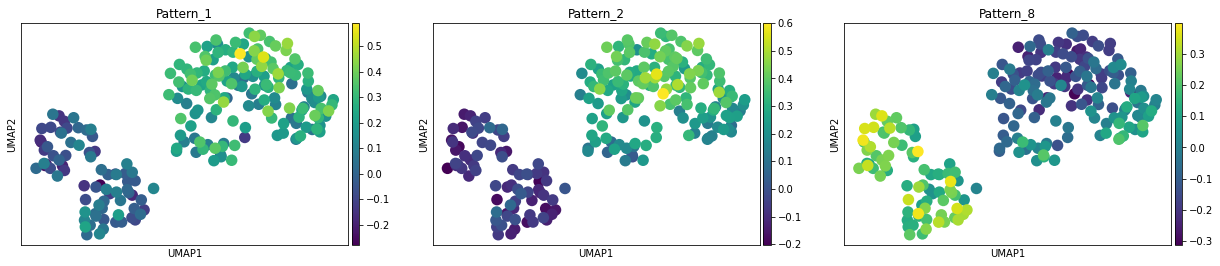

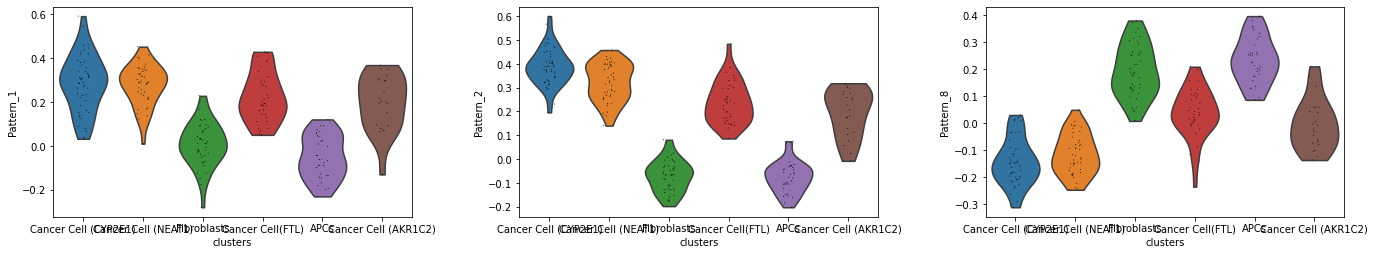

In [21]:
sc.pl.umap(adata, color = projectionCoGAPs.columns[:-1], ncols=3, save='')

sc.pl.violin(adata,  projectionCoGAPs.columns[:-1], groupby='clusters')

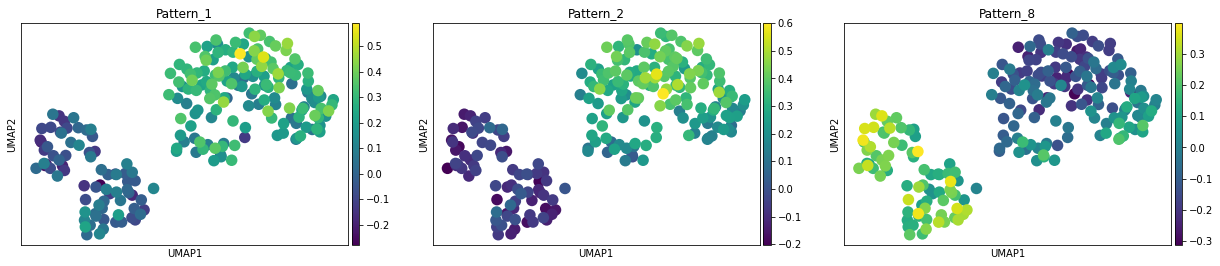

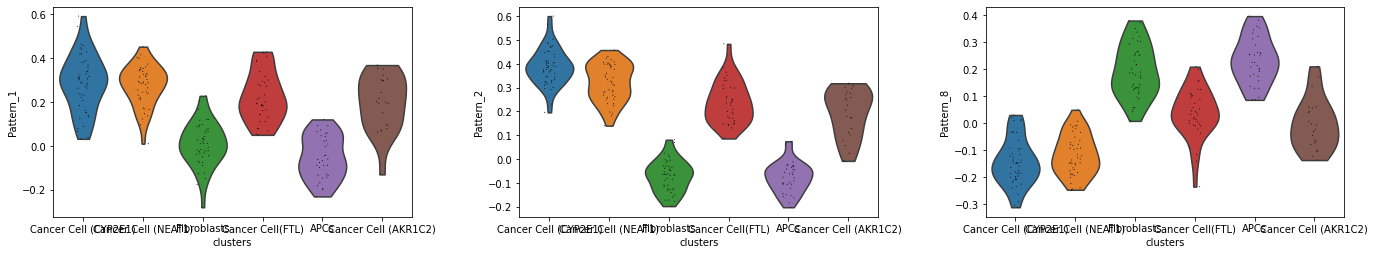

In [22]:
sc.pl.umap(adata, color = ['Pattern_1', 'Pattern_2', 'Pattern_8'])
sc.pl.violin(adata,  ['Pattern_1', 'Pattern_2', 'Pattern_8'], groupby='clusters')


In [23]:
high_exp_gene_1 = set(adata.var[adata.var['n_cells'] >= 5].index)
high_exp_gene_2 = set(adata.var[adata.var['n_cells'] >= 40].index)

p1p8_gene = set(p1p8_matrix.index)
p2p8_gene = set(p2p8_matrix.index)

In [24]:
# Gene will be plotted in heatmap
p1p8 = p1p8_gene.intersection(high_exp_gene_1)
p2p8 = p2p8_gene.intersection(high_exp_gene_2)

In [25]:
p2p8

{'ADH1B',
 'AHSG',
 'AKR1C1',
 'AKR1C2',
 'AKR1C3',
 'AKR1C4',
 'ALDH1A1',
 'ALDH1L1',
 'APOC2',
 'ASGR1',
 'ATP5F1D',
 'ATP5F1E',
 'ATP5MC2',
 'ATP5MC3',
 'BAAT',
 'BTF3',
 'CALD1',
 'CANX',
 'CBR1',
 'CES1',
 'CFH',
 'CFL1',
 'CHCHD10',
 'CHCHD2',
 'COX4I1',
 'COX6A1',
 'COX6C',
 'CYB5A',
 'CYP27A1',
 'CYP2E1',
 'EEF1B2',
 'EEF1D',
 'EIF1',
 'ETFB',
 'FABP1',
 'FGA',
 'FGB',
 'FN1',
 'GABARAP',
 'GALK1',
 'GGH',
 'GLUD1',
 'GLUL',
 'GPX4',
 'GRHPR',
 'GSTO1',
 'H3F3A',
 'HINT1',
 'HLA-C',
 'HNRNPA1',
 'HPR',
 'HSP90AA1',
 'HSP90AB1',
 'HSPA5',
 'HSPA8',
 'HSPB1',
 'HSPD1',
 'IGFBP2',
 'ITM2B',
 'LEAP2',
 'MGST1',
 'MTDH',
 'MYL6',
 'NACA',
 'NDUFA11',
 'NDUFA13',
 'NME2',
 'NPM1',
 'NQO1',
 'OAZ1',
 'P4HB',
 'PABPC1',
 'PAH',
 'PDIA3',
 'PFN1',
 'PPIA',
 'PPIB',
 'PPP1R16A',
 'PRDX1',
 'PSAP',
 'PSMA7',
 'PTGR1',
 'PTMA',
 'RARRES2',
 'RNASEK',
 'RPL10A',
 'RPL14',
 'RPL15',
 'RPL23A',
 'RPL27',
 'RPL31',
 'RPL34',
 'RPL5',
 'RPL7',
 'RPL7A',
 'RPS21',
 'RPS24',
 'RPS9',
 'SAT1',
 'S

In [26]:
adata.var.loc['S100A6']

gene_ids                 ENSG00000197956
feature_types            Gene Expression
mt                                 False
ribo                               False
hb                                 False
n_cells_by_counts                     64
mean_counts                     0.091743
pct_dropout_by_counts          95.483416
total_counts                       130.0
n_cells                               32
Name: S100A6, dtype: object

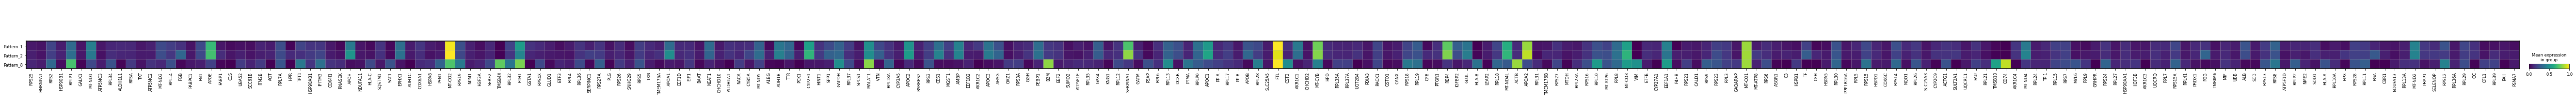

In [27]:
sc.pl.matrixplot(adata, list(high_exp_gene_2),groupby='Pattern_Cluster', standard_scale = 'group')

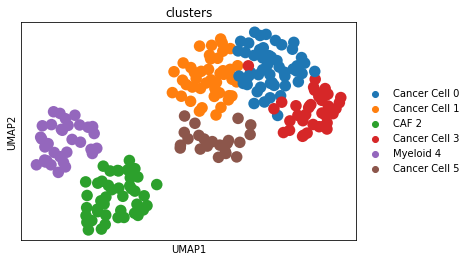

In [28]:
new_cluster_names = ['Cancer Cell 0', 'Cancer Cell 1', 'CAF 2', 'Cancer Cell 3', 'Myeloid 4',
                     'Cancer Cell 5']

adata.rename_categories('clusters', new_cluster_names)
#This section primarily from squidpy tutorial (using seqFISH data), which is available at: 
 #   https://squidpy.readthedocs.io/en/latest/auto_tutorials/tutorial_seqfish.html

# Better to work on once all regions are defined
# Neighborhood enrichment analysis
sc.pl.umap(adata, color = ['clusters'])

In [29]:
adata.write('../../pySCENIC/SingleCell/{}/classified_single_cell.h5ad'.format(patient),
    compression='gzip')

In [31]:
p2_add = ['HLA-DPB1', 'HLA-DPA1', 'COL4A1', 'COL4A2', 'CD14']
p2p8_list = list(p2p8)+p2_add

adata_sub_1 = adata[:, list(p1p8)]
adata_sub_2 = adata[:, list(p2p8)]

pattern_list_1 = ['Pattern_1', 'Pattern_8']
pattern_list_2 = ['Pattern_2', 'Pattern_8']

def subset_df(adata_sub, pattern_list):
    heatmap_total = pd.DataFrame(data = adata_sub.X.toarray(), columns=adata_sub.var_names, index=adata_sub.obs_names)
    #Remove row sum equal to zero
    heatmap_total = heatmap_total.loc[(heatmap_total.sum(axis=1) != 0)]
    heatmap_total['Pattern_Cluster'] = adata_sub.obs['Pattern_Cluster']
    heatmap_total= heatmap_total.sort_values(by='Pattern_Cluster')
    heatmap_total = heatmap_total[heatmap_total['Pattern_Cluster'].isin(pattern_list)]
    return heatmap_total

#Subset tp 
heatmap_total_1 = subset_df(adata_sub_1, pattern_list_1)

heatmap_total_2 = subset_df(adata_sub_2, pattern_list_2)

In [32]:
palette = sns.color_palette()
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [33]:
heatmap_total_1.columns[-1]
color_dict_col_1 = {}
#color legend of pattern1-pattern8
color_dict_col_Legend_1 = { "Pattern_1": palette[0], "Pattern_8": palette[2]}
#color legend of pattern2-pattern8
color_dict_col_Legend_2 = { "Pattern_2": palette[1], "Pattern_8": palette[2]}

for ele in heatmap_total_1.index:
    if heatmap_total_1.loc[ele]['Pattern_Cluster'] == 'Pattern_1':
        color_dict_col_1[ele] = palette[0]
    if heatmap_total_1.loc[ele]['Pattern_Cluster'] == 'Pattern_2':
        color_dict_col_1[ele] = palette[1]
    if heatmap_total_1.loc[ele]['Pattern_Cluster'] == 'Pattern_8':
        color_dict_col_1[ele] = palette[2]
color_cols_1 = pd.Series(color_dict_col_1)

In [34]:
heatmap_total_2.columns[-1]
color_dict_col_2 = {}

#color legend of pattern2-pattern8
color_dict_col_Legend_2 = { "Pattern_2": palette[1], "Pattern_8": palette[2]}

for ele in heatmap_total_2.index:
    if heatmap_total_2.loc[ele]['Pattern_Cluster'] == 'Pattern_1':
        color_dict_col_2[ele] = palette[0]
    if heatmap_total_2.loc[ele]['Pattern_Cluster'] == 'Pattern_2':
        color_dict_col_2[ele] = palette[1]
    if heatmap_total_2.loc[ele]['Pattern_Cluster'] == 'Pattern_8':
        color_dict_col_2[ele] = palette[2]
color_cols_2 = pd.Series(color_dict_col_2)

In [35]:
## Prepare for the heatmap plot

AAACGGGGTCAAAGCG-2    (0.12156862745098039, 0.4666666666666667, 0.70...
CAGGTGCCAGTCTTCC-2    (0.12156862745098039, 0.4666666666666667, 0.70...
GCTTGAATCGATAGAA-2    (0.12156862745098039, 0.4666666666666667, 0.70...
GGACGTCAGACGCACA-2    (0.12156862745098039, 0.4666666666666667, 0.70...
GGGCATCAGATGTCGG-2    (0.12156862745098039, 0.4666666666666667, 0.70...
                                            ...                        
ATTGGACAGCCGTCGT-2    (0.17254901960784313, 0.6274509803921569, 0.17...
ATTGGTGCAGCCACCA-2    (0.17254901960784313, 0.6274509803921569, 0.17...
GGTATTGGTAGCTTGT-2    (0.17254901960784313, 0.6274509803921569, 0.17...
GGCTGGTAGTCCGTAT-2    (0.17254901960784313, 0.6274509803921569, 0.17...
GACGCGTTCCGTTGTC-2    (0.17254901960784313, 0.6274509803921569, 0.17...
Length: 115, dtype: object

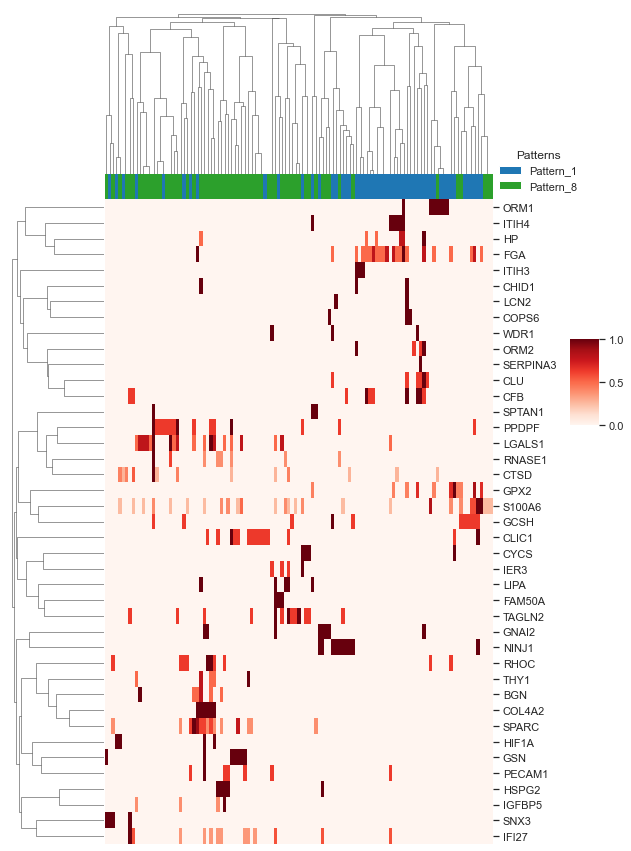

In [36]:
sns.set(font_scale=1)
ax = sns.clustermap(heatmap_total_1[heatmap_total_1.columns[:-1]].T, metric='correlation',
                    figsize=(8, 12), cmap='Reds', col_colors=[color_cols_1], 
                    xticklabels=False, standard_scale=0, yticklabels=True,
                    cbar_kws={'shrink': 0.4}, cbar_pos=(1, 0.5, 0.05, 0.1))

handles = [Patch(facecolor=color_dict_col_Legend_1[name]) for name in color_dict_col_Legend_1]
plt.legend(handles, color_dict_col_Legend_1, title='Patterns', frameon=False,
           bbox_to_anchor=(1.03, 0.83), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.savefig('figures/p1p8_heatmap.png', dpi=600)

C:\Users\Owner\anaconda3\envs\visium\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


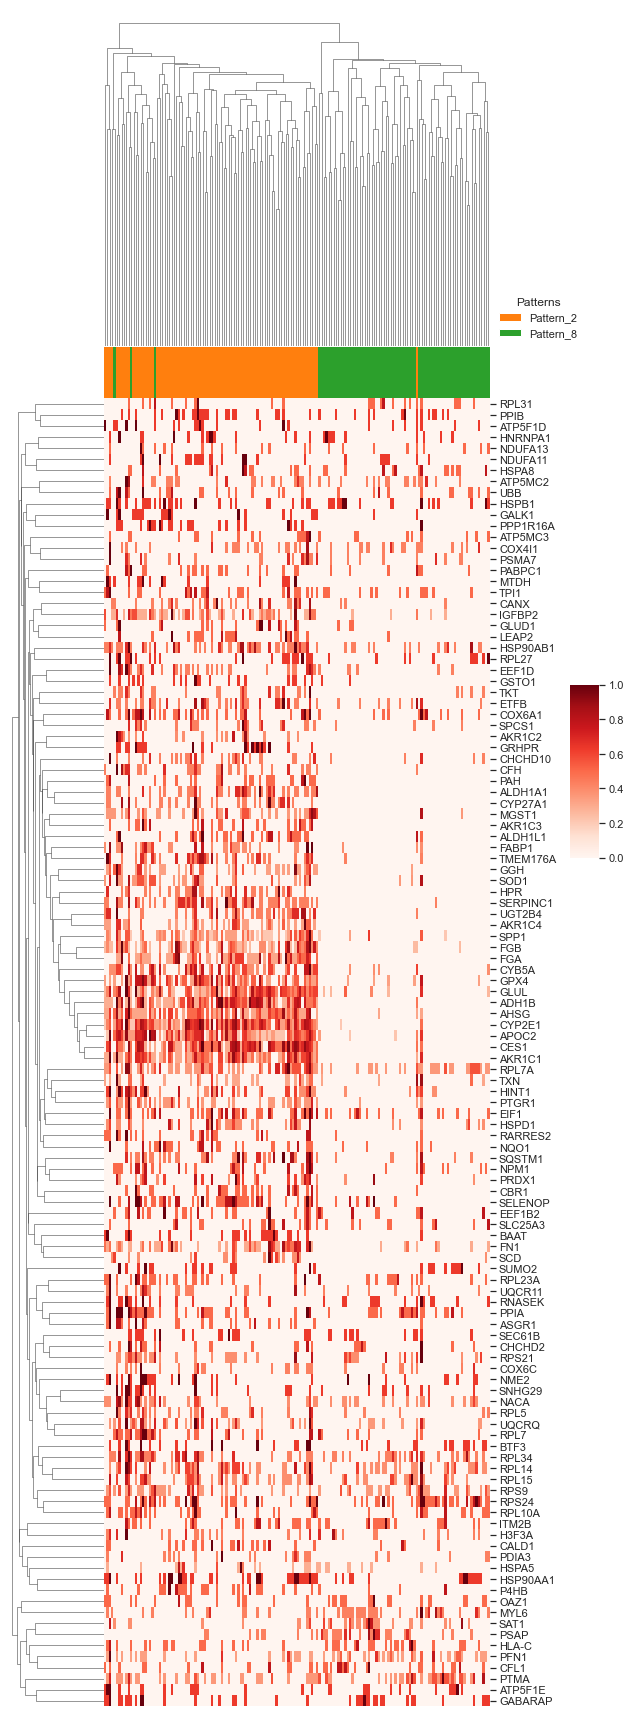

In [37]:
sns.set(font_scale=1)
ax = sns.clustermap(heatmap_total_2[heatmap_total_2.columns[:-1]].T, metric='correlation',
                    figsize=(8, 24), cmap='Reds', col_colors=[color_cols_2], 
                    xticklabels=False, standard_scale=0, yticklabels=True,
                    cbar_kws={'shrink': 0.4}, cbar_pos=(1, 0.5, 0.05, 0.1))

handles = [Patch(facecolor=color_dict_col_Legend_2[name]) for name in color_dict_col_Legend_2]
plt.legend(handles, color_dict_col_Legend_2, title='Patterns', frameon=False,
           bbox_to_anchor=(1.03, 0.83), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.savefig('figures/p2p8_heatmap.png', dpi=600)